## Importing the relevant packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.arima_model import ARIMA, ARMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from scipy.stats.distributions import chi2 
from math import sqrt
import seaborn as sns
sns.set()

In [2]:
from influxdb_client import InfluxDBClient

In [3]:
import warnings
warnings.filterwarnings("ignore")

## Importing the Data and Pre-processing 

In [4]:
#Auth parameters
my_token = "yaKfFeAsha8tNAZxvYeZBMmq-khO8tz-6Ut_PARgohiWzeW2j8BB86ND33Qbq7hR8bylmOROPQAUr-7M103_Yw=="
my_org = "iot-org"
bucket = "iot-demo"
client = InfluxDBClient(url="http://192.168.1.100:9999", token=my_token, org=my_org, debug=False)

In [21]:
queryTemperature = '''
from(bucket: "iot-demo")
  |> range(start: -4d, stop: now())
  |> filter(fn: (r) => r["_measurement"] == "temperature")
  |> filter(fn: (r) => r["device"] == "RoomWeather")
  |> aggregateWindow(every: 10m, fn: median)
  '''

queryHumidity = '''
from(bucket: "iot-demo")
  |> range(start: -4d, stop: now())
  |> filter(fn: (r) => r["_measurement"] == "humidity")
  |> filter(fn: (r) => r["device"] == "RoomWeather")
  |> aggregateWindow(every: 10m, fn: median)
  '''

queryPressure = '''
from(bucket: "iot-demo")
  |> range(start: -4d, stop: now())
  |> filter(fn: (r) => r["_measurement"] == "pressure")
  |> filter(fn: (r) => r["device"] == "RoomWeather")
  |> aggregateWindow(every: 10m, fn: median)
  '''

In [22]:
#Query InfluxDB and return a Dataframe
dfTemp = client.query_api().query_data_frame(org=my_org, query=queryTemperature)
dfHum = client.query_api().query_data_frame(org=my_org, query=queryHumidity)
dfPress = client.query_api().query_data_frame(org=my_org, query=queryPressure)

In [23]:
dfTemp.head()

,result,table,_start,_stop,_field,_measurement,device,location,_value,_time
0,_result,0,2020-07-07 17:44:50.524270+00:00,2020-07-11 17:44:50.524270+00:00,value,temperature,RoomWeather,ubuntu,30.65,2020-07-07 17:50:00+00:00
1,_result,0,2020-07-07 17:44:50.524270+00:00,2020-07-11 17:44:50.524270+00:00,value,temperature,RoomWeather,ubuntu,30.60,2020-07-07 18:00:00+00:00
2,_result,0,2020-07-07 17:44:50.524270+00:00,2020-07-11 17:44:50.524270+00:00,value,temperature,RoomWeather,ubuntu,30.70,2020-07-07 18:10:00+00:00
3,_result,0,2020-07-07 17:44:50.524270+00:00,2020-07-11 17:44:50.524270+00:00,value,temperature,RoomWeather,ubuntu,30.65,2020-07-07 18:20:00+00:00
4,_result,0,2020-07-07 17:44:50.524270+00:00,2020-07-11 17:44:50.524270+00:00,value,temperature,RoomWeather,ubuntu,30.65,2020-07-07 18:30:00+00:00


In [24]:
dfHum.head()

,result,table,_start,_stop,_field,_measurement,device,location,_value,_time
0,_result,0,2020-07-07 17:44:52.892648+00:00,2020-07-11 17:44:52.892648+00:00,value,humidity,RoomWeather,ubuntu,35.2,2020-07-07 17:50:00+00:00
1,_result,0,2020-07-07 17:44:52.892648+00:00,2020-07-11 17:44:52.892648+00:00,value,humidity,RoomWeather,ubuntu,35.2,2020-07-07 18:00:00+00:00
2,_result,0,2020-07-07 17:44:52.892648+00:00,2020-07-11 17:44:52.892648+00:00,value,humidity,RoomWeather,ubuntu,35.3,2020-07-07 18:10:00+00:00
3,_result,0,2020-07-07 17:44:52.892648+00:00,2020-07-11 17:44:52.892648+00:00,value,humidity,RoomWeather,ubuntu,35.3,2020-07-07 18:20:00+00:00
4,_result,0,2020-07-07 17:44:52.892648+00:00,2020-07-11 17:44:52.892648+00:00,value,humidity,RoomWeather,ubuntu,35.6,2020-07-07 18:30:00+00:00


In [25]:
dfPress.head()

,result,table,_start,_stop,_field,_measurement,device,location,_value,_time
0,_result,0,2020-07-07 17:44:55.468009+00:00,2020-07-11 17:44:55.468009+00:00,value,pressure,RoomWeather,ubuntu,NaN,2020-07-07 17:50:00+00:00
1,_result,0,2020-07-07 17:44:55.468009+00:00,2020-07-11 17:44:55.468009+00:00,value,pressure,RoomWeather,ubuntu,NaN,2020-07-07 18:00:00+00:00
2,_result,0,2020-07-07 17:44:55.468009+00:00,2020-07-11 17:44:55.468009+00:00,value,pressure,RoomWeather,ubuntu,NaN,2020-07-07 18:10:00+00:00
3,_result,0,2020-07-07 17:44:55.468009+00:00,2020-07-11 17:44:55.468009+00:00,value,pressure,RoomWeather,ubuntu,NaN,2020-07-07 18:20:00+00:00
4,_result,0,2020-07-07 17:44:55.468009+00:00,2020-07-11 17:44:55.468009+00:00,value,pressure,RoomWeather,ubuntu,NaN,2020-07-07 18:30:00+00:00


In [26]:
df = pd.DataFrame(dfTemp['_time']).rename(columns={'_time':'time'})
df['temperature'] = dfTemp['_value']
df['humidity'] = dfHum['_value']
df['pressure'] = dfPress['_value']
df = df.set_index('time')
df.head()

,temperature,humidity,pressure
time,,,
2020-07-07 17:50:00+00:00,30.65,35.2,NaN
2020-07-07 18:00:00+00:00,30.60,35.2,NaN
2020-07-07 18:10:00+00:00,30.70,35.3,NaN
2020-07-07 18:20:00+00:00,30.65,35.3,NaN
2020-07-07 18:30:00+00:00,30.65,35.6,NaN


# Fill NaN values

In [27]:
df['temperature'] = df['temperature'].fillna(method='backfill')
df['humidity'] = df['humidity'].fillna(method='backfill')
df['pressure'] = df['pressure'].fillna(method='backfill').fillna(method='ffill')

In [28]:
df_dim = len(df)

In [29]:
print(df['temperature'].isnull().sum())
print(df['humidity'].isnull().sum())
print(df['pressure'].isnull().sum())

0
0
0


# Split the dataset

In [30]:
# divide in train e test
size = int(len(df)*0.8)
df_train, df_test = df.iloc[:size], df.iloc[size:]

# Dickey–Fuller test

In [31]:
sts.adfuller(df.temperature) # non stazionaria

(-3.2594227444772894,
 0.016792619922708987,
 17,
 559,
 {'1%': -3.442102384299813,
  '5%': -2.8667242618524233,
  '10%': -2.569531046591633},
 -716.9580691663491)

In [32]:
sts.adfuller(df.humidity) # non stazionaria

(-1.9191971054399606,
 0.32308477238908573,
 1,
 575,
 {'1%': -3.4417738839904657,
  '5%': -2.8665796253604015,
  '10%': -2.569453974291115},
 164.4614142950444)

In [33]:
sts.adfuller(df.pressure) # non stazionaria

(-1.2266654072146113,
 0.6620210482063118,
 2,
 574,
 {'1%': -3.4417938762914972,
  '5%': -2.866588428280353,
  '10%': -2.5694586650317475},
 -153.69686986586305)

## The LLR Test

In [34]:
def LLR_test(mod_1, mod_2, DF = 1):
    L1 = mod_1.llf
    L2 = mod_2.llf
    LR = (2*(L2-L1))    
    p = chi2.sf(LR, DF).round(3)
    return p

## Auto Correlation Function (ACF)

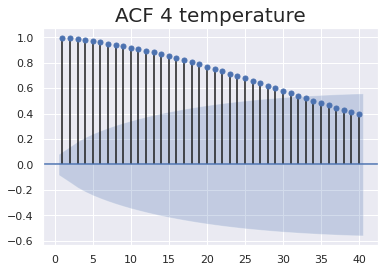

In [35]:
sgt.plot_acf(df.temperature, zero = False, lags = 40)
plt.title("ACF 4 temperature", size = 20)
plt.show()

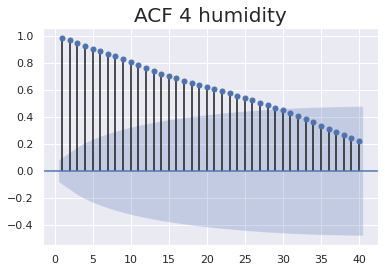

In [36]:
sgt.plot_acf(df.humidity, zero = False, lags = 40)
plt.title("ACF 4 humidity", size = 20)
plt.show()

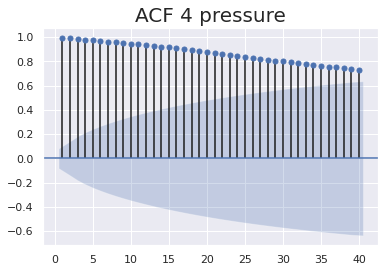

In [37]:
sgt.plot_acf(df.pressure, zero = False, lags = 40)
plt.title("ACF 4 pressure", size = 20)
plt.show()

## Partial Auto Correlation Function (PACF)

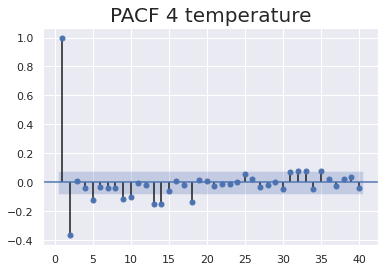

In [38]:
sgt.plot_pacf(df.temperature, lags = 40, alpha = 0.05, zero = False, method = ('ols'))
plt.title("PACF 4 temperature", size = 20)
plt.show()

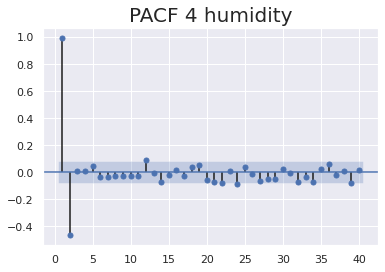

In [39]:
sgt.plot_pacf(df.humidity, lags = 40, alpha = 0.05, zero = False, method = ('ols'))
plt.title("PACF 4 humidity", size = 20)
plt.show()

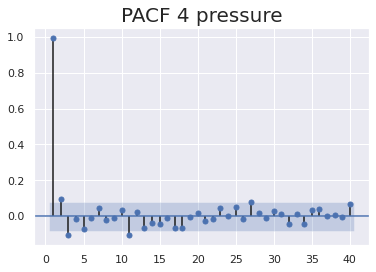

In [40]:
sgt.plot_pacf(df.pressure, lags = 40, alpha = 0.05, zero = False, method = ('ols'))
plt.title("PACF 4 pressure", size = 20)
plt.show()

# Temperature

## AR(1)

In [41]:
model_t_ar_1 = ARIMA(df.temperature, order=(1,0,0))
results_t_ar_1 = model_t_ar_1.fit()
results_t_ar_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:            temperature   No. Observations:                  577
Model:                     ARMA(1, 0)   Log Likelihood                 316.005
Method:                       css-mle   S.D. of innovations              0.139
Date:                Sat, 11 Jul 2020   AIC                           -626.009
Time:                        19:45:31   BIC                           -612.936
Sample:                             0   HQIC                          -620.911
                                                                              
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                31.1279      1.261     24.682      0.000      28.656      33.600
ar.L1.temperature     0.9968      0.003    397.493      0.000       0.992       1.002
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0033           +0.0000j            1.0033            0.0000
-----------------------------------------------------------------------------
"""

## AR(2)

In [42]:
model_t_ar_2 = ARIMA(df.temperature, order=(2,0,0))
results_t_ar_2 = model_t_ar_2.fit()
results_t_ar_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:            temperature   No. Observations:                  577
Model:                     ARMA(2, 0)   Log Likelihood                 357.228
Method:                       css-mle   S.D. of innovations              0.130
Date:                Sat, 11 Jul 2020   AIC                           -706.457
Time:                        19:45:37   BIC                           -689.026
Sample:                             0   HQIC                          -699.659
                                                                              
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                30.9487      1.079     28.670      0.000      28.833      33.064
ar.L1.temperature     1.3606      0.039     35.180      0.000       1.285       1.436
ar.L2.temperature    -0.3647      0.039     -9.422      0.000      -0.441      -0.289
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0065           +0.0000j            1.0065            0.0000
AR.2            2.7245           +0.0000j            2.7245            0.0000
-----------------------------------------------------------------------------
"""

## AR(3)

In [43]:
model_t_ar_3 = ARIMA(df.temperature, order=(3,0,0))
results_t_ar_3 = model_t_ar_3.fit()
results_t_ar_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:            temperature   No. Observations:                  577
Model:                     ARMA(3, 0)   Log Likelihood                 357.255
Method:                       css-mle   S.D. of innovations              0.130
Date:                Sat, 11 Jul 2020   AIC                           -704.511
Time:                        19:45:43   BIC                           -682.721
Sample:                             0   HQIC                          -696.014
                                                                              
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                30.9540      1.086     28.514      0.000      28.826      33.082
ar.L1.temperature     1.3641      0.042     32.811      0.000       1.283       1.446
ar.L2.temperature    -0.3779      0.069     -5.498      0.000      -0.513      -0.243
ar.L3.temperature     0.0097      0.042      0.232      0.817      -0.072       0.091
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0064           +0.0000j            1.0064            0.0000
AR.2            2.9239           +0.0000j            2.9239            0.0000
AR.3           35.1481           +0.0000j           35.1481            0.0000
-----------------------------------------------------------------------------
"""

In [44]:
print("\nLLR test AR(1)-AR(2) = " + str(LLR_test(results_t_ar_1, results_t_ar_2)))
print("\nLLR test AR(2)-AR(3) = " + str(LLR_test(results_t_ar_2, results_t_ar_3)))


LLR test AR(1)-AR(2) = 0.0

LLR test AR(2)-AR(3) = 0.817


## Analysis of Residuals AR

(-3.1536291343770912, 0.022830661247345712, 16, 560, {'1%': -3.442081300525009, '5%': -2.8667149792729596, '10%': -2.569526100127551}, -711.7944259024739)


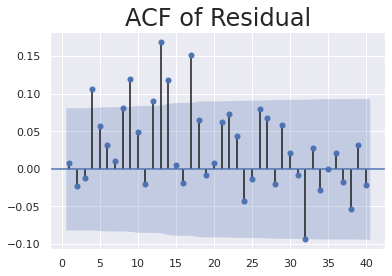

In [60]:
df['res_temp'] = results_t_ar_2.resid
print(sts.adfuller(df.res_temp))
sgt.plot_acf(df.res_temp, zero = False, lags = 40)
plt.title("ACF of Residual", size=24)
plt.show()

In [46]:
del df['res_temp']

## MA(1)

In [48]:
model_t_ma_1 = SARIMAX(df.temperature, order=(0,0,1))
results_t_ma_1 = model_t_ma_1.fit()

#model_t_ma_2 = ARIMA(df.temperature, order=(0,0,2))
#results_t_ma_2 = model_t_ma_2.fit(start_ar_lags=100)

#model_t_ma_3 = SARIMAX(df.temperature, order=(0,0,3))
#results_t_ma_3 = model_t_ma_3.fit()

#model_t_ma_4 = SARIMAX(df.temperature, order=(0,0,4))
#results_t_ma_4 = model_t_ma_4.fit()

In [49]:
results_t_ma_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            temperature   No. Observations:                  577
Model:               SARIMAX(0, 0, 1)   Log Likelihood               -2397.092
Date:                Sat, 11 Jul 2020   AIC                           4798.183
Time:                        19:46:39   BIC                           4806.899
Sample:                             0   HQIC                          4801.582
                                - 577                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.9991      0.138      7.218      0.000       0.728       1.270
sigma2       235.2383    148.064      1.589      0.112     -54.962     525.439
===================================================================================
Ljung-Box (Q):                     9602.96   Jarque-Bera (JB):                49.40
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.22   Skew:                             0.21
Prob(H) (two-sided):                  0.17   Kurtosis:                         4.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [50]:
#results_t_ma_2.summary()

In [51]:
#results_t_ma_3.summary()

In [52]:
#results_t_ma_4.summary()

## ARMA(1,1)

In [53]:
reults_t_ar_1_ma_1 = ARMA(df.temperature, order=(1,1)).fit()
reults_t_ar_1_ma_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:            temperature   No. Observations:                  577
Model:                     ARMA(1, 1)   Log Likelihood                 353.032
Method:                       css-mle   S.D. of innovations              0.131
Date:                Sat, 11 Jul 2020   AIC                           -698.064
Time:                        19:46:48   BIC                           -680.633
Sample:                             0   HQIC                          -691.266
                                                                              
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                31.0315      1.169     26.552      0.000      28.741      33.322
ar.L1.temperature     0.9952      0.003    301.534      0.000       0.989       1.002
ma.L1.temperature     0.3317      0.035      9.464      0.000       0.263       0.400
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0048           +0.0000j            1.0048            0.0000
MA.1           -3.0147           +0.0000j            3.0147            0.5000
-----------------------------------------------------------------------------
"""

In [54]:
print("\nARMA(1,1) vs AR(1) ",LLR_test(results_t_ar_1, reults_t_ar_1_ma_1))
print("\nARMA(1,1) vs AR(2) ",LLR_test(results_t_ar_2, reults_t_ar_1_ma_1))
print("\nARMA(1,1) vs MA(1) ",LLR_test(results_t_ma_1, reults_t_ar_1_ma_1))


ARMA(1,1) vs AR(1)  0.0

ARMA(1,1) vs AR(2)  1.0

ARMA(1,1) vs MA(1)  0.0


## Higher order ARMA

In [55]:
reults_t_ar_2_ma_1 = ARMA(df.temperature, order=(2,1)).fit()

In [56]:
print("\nARMA(1,1) vs ARMA(2,1) ",LLR_test(reults_t_ar_1_ma_1, reults_t_ar_2_ma_1))


ARMA(1,1) vs ARMA(2,1)  0.004


In [57]:
print("\nAR(2) vs ARMA(2,1) ",LLR_test(results_t_ar_2, reults_t_ar_2_ma_1))


AR(2) vs ARMA(2,1)  0.799


## Analysis of Residuals ARMA


(-3.1536291343770912, 0.022830661247345712, 16, 560, {'1%': -3.442081300525009, '5%': -2.8667149792729596, '10%': -2.569526100127551}, -711.7944259024739)

0.00010700076808555509

0.016999000936067002


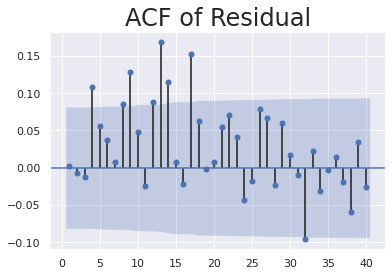

In [61]:
print("\n"+str(sts.adfuller(df.res_temp)))
print("\n"+str(df.res_temp.mean()))
print("\n"+str(df.res_temp.var()))
sgt.plot_acf(reults_t_ar_2_ma_1.resid.iloc[:][1:], zero = False, lags = 40)
plt.title("ACF of Residual", size=24)
plt.show()

In [44]:

#print(sts.adfuller(df.res_temp))
# df.temperature.plot(figsize=(25,10), color = 'pink')
# reults_t_ar_2_ma_1.fittedvalues.plot(color = 'blue')
# results_t_ar_2.fittedvalues.plot(color = 'yellow')

# sgt.plot_acf(reults_t_ar_2_ma_1.fittedvalues , zero = False, lags = 40)
# sgt.plot_acf(df.temperature , zero = False, lags = 40)
# plt.title("ACF of Residual", size=24)
# plt.show()

## ARIMA (1,1,1)

In [64]:
results_t_ar_1_i_1_ma_1 = ARIMA(df.temperature, order=(1,1,1)).fit()
results_t_ar_1_i_1_ma_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:          D.temperature   No. Observations:                  576
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 358.308
Method:                       css-mle   S.D. of innovations              0.130
Date:                Sat, 11 Jul 2020   AIC                           -708.615
Time:                        19:51:05   BIC                           -691.191
Sample:                             1   HQIC                          -701.820
                                                                              
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.0034      0.008      0.403      0.687      -0.013       0.020
ar.L1.D.temperature     0.3272      0.113      2.891      0.004       0.105       0.549
ma.L1.D.temperature     0.0410      0.121      0.340      0.734      -0.195       0.277
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            3.0558           +0.0000j            3.0558            0.0000
MA.1          -24.4055           +0.0000j           24.4055            0.5000
-----------------------------------------------------------------------------
"""

In [65]:
results_t_ar_1_i_1_ma_0 = ARIMA(df.temperature, order=(1,1,0)).fit()
results_t_ar_1_i_1_ma_0.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:          D.temperature   No. Observations:                  576
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 358.252
Method:                       css-mle   S.D. of innovations              0.130
Date:                Sat, 11 Jul 2020   AIC                           -710.503
Time:                        19:51:05   BIC                           -697.435
Sample:                             1   HQIC                          -705.407
                                                                              
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.0034      0.008      0.397      0.692      -0.013       0.020
ar.L1.D.temperature     0.3628      0.039      9.355      0.000       0.287       0.439
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            2.7561           +0.0000j            2.7561            0.0000
-----------------------------------------------------------------------------
"""

In [66]:
print("\nARMA(1,1) vs ARIMA(1,1,1) ", LLR_test(reults_t_ar_1_ma_1, results_t_ar_1_i_1_ma_1))
print("\nARMA(2,1) vs ARIMA(1,1,1) ", LLR_test(reults_t_ar_2_ma_1, results_t_ar_1_i_1_ma_1))
print("\nAR(2) vs ARIMA(1,1,1) ", LLR_test(results_t_ar_2, results_t_ar_1_i_1_ma_1))

#confrontare con il migliore trovato fino ad ora


ARMA(1,1) vs ARIMA(1,1,1)  0.001

ARMA(2,1) vs ARIMA(1,1,1)  0.148

AR(2) vs ARIMA(1,1,1)  0.142


In [67]:
print("\nARMA(1,1) vs ARIMA(1,1,0) ", LLR_test(reults_t_ar_1_ma_1, results_t_ar_1_i_1_ma_0))
print("\nARMA(2,1) vs ARIMA(1,1,0) ", LLR_test(reults_t_ar_2_ma_1, results_t_ar_1_i_1_ma_0))
print("\nAR(2) vs ARIMA(1,1,0) ", LLR_test(results_t_ar_2, results_t_ar_1_i_1_ma_0))

#confrontare con il migliore trovato fino ad ora


ARMA(1,1) vs ARIMA(1,1,0)  0.001

ARMA(2,1) vs ARIMA(1,1,0)  0.159

AR(2) vs ARIMA(1,1,0)  0.153


## Residuals of the ARIMA(1,1,1)

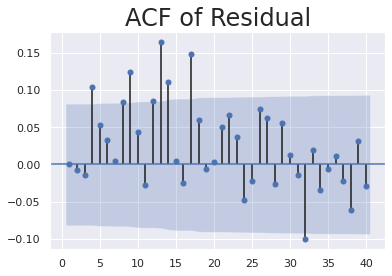

In [68]:
#print(sts.adfuller(df.res_temp))
sgt.plot_acf(results_t_ar_1_i_1_ma_1.resid.iloc[:][1:], zero = False, lags = 40)
plt.title("ACF of Residual", size=24)
plt.show()

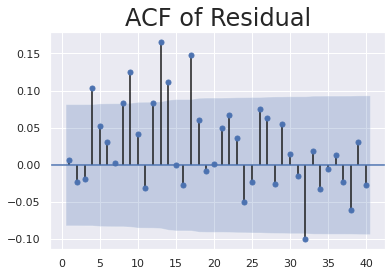

In [69]:
#print(sts.adfuller(df.res_temp))
sgt.plot_acf(results_t_ar_1_i_1_ma_0.resid.iloc[:][1:], zero = False, lags = 40)
plt.title("ACF of Residual", size=24)
plt.show()

In [48]:
del df['res_temp']

## Higher order ARIMA

In [49]:
results_t_ar_1_i_1_ma_1 = ARIMA(df.temperature, order=(1,1,1)).fit()
results_t_ar_2_i_1_ma_1 = ARIMA(df.temperature, order=(2,1,1)).fit()
results_t_ar_3_i_1_ma_1 = ARIMA(df.temperature, order=(3,1,1)).fit()
results_t_ar_4_i_1_ma_1 = ARIMA(df.temperature, order=(4,1,1)).fit()

results_t_ar_1_i_1_ma_2 = ARIMA(df.temperature, order=(1,1,2)).fit()
results_t_ar_2_i_1_ma_2 = ARIMA(df.temperature, order=(2,1,2)).fit()
results_t_ar_3_i_1_ma_2 = ARIMA(df.temperature, order=(3,1,2)).fit()
results_t_ar_4_i_1_ma_2 = ARIMA(df.temperature, order=(4,1,2)).fit()

In [71]:
results_t_ar_1_i_1_ma_0 = ARIMA(df.temperature, order=(1,1,0)).fit() #solo questo ne vale la pena
results_t_ar_2_i_1_ma_0 = ARIMA(df.temperature, order=(2,1,0)).fit()
results_t_ar_3_i_1_ma_0 = ARIMA(df.temperature, order=(3,1,0)).fit()
results_t_ar_4_i_1_ma_0 = ARIMA(df.temperature, order=(4,1,0)).fit()

#print(results_t_ar_1_i_1_ma_0.summary())
#print(results_t_ar_2_i_1_ma_0.summary())
#print(results_t_ar_3_i_1_ma_0.summary())
#print(results_t_ar_4_i_1_ma_0.summary())


In [50]:
# print("ARIMA(1,1,1):  \t LL = ", results_t_ar_1_i_1_ma_1.llf, "\t AIC = ", results_t_ar_1_i_1_ma_1.aic)
# print("ARIMA(2,1,1):  \t LL = ", results_t_ar_2_i_1_ma_1.llf, "\t AIC = ", results_t_ar_2_i_1_ma_1.aic)
print("ARIMA(3,1,1):  \t LL = ", results_t_ar_3_i_1_ma_1.llf, "\t AIC = ", results_t_ar_3_i_1_ma_1.aic)
# print("ARIMA(4,1,1):  \t LL = ", results_t_ar_4_i_1_ma_1.llf, "\t AIC = ", results_t_ar_4_i_1_ma_1.aic)
print("ARIMA(1,1,2):  \t LL = ", results_t_ar_1_i_1_ma_2.llf, "\t AIC = ", results_t_ar_1_i_1_ma_2.aic)
# print("ARIMA(2,1,2):  \t LL = ", results_t_ar_2_i_1_ma_2.llf, "\t AIC = ", results_t_ar_2_i_1_ma_2.aic)
print("ARIMA(3,1,2):  \t LL = ", results_t_ar_3_i_1_ma_2.llf, "\t AIC = ", results_t_ar_3_i_1_ma_2.aic)
# print("ARIMA(4,1,2):  \t LL = ", results_t_ar_4_i_1_ma_2.llf, "\t AIC = ", results_t_ar_4_i_1_ma_2.aic)

# dato che ARIMA(3,1,2) contiene ARIMA(3,1,1) e ARIMA(1,1,2) vediamo se la maggiore complessità del modello 
# ne giustifica l'utilizzo al posto degli altri due --> LLR test 

ARIMA(3,1,1):  	 LL =  254.30256856512847 	 AIC =  -496.60513713025694
ARIMA(1,1,2):  	 LL =  250.33257657200988 	 AIC =  -490.66515314401977
ARIMA(3,1,2):  	 LL =  261.1440191451104 	 AIC =  -508.2880382902208


In [51]:
print("\nARIMA(3,1,1) vs ARIMA(3,1,2) ",LLR_test(results_t_ar_3_i_1_ma_1, results_t_ar_3_i_1_ma_2))
print("\nARIMA(1,1,2) vs ARIMA(3,1,2) ",LLR_test(results_t_ar_1_i_1_ma_2, results_t_ar_3_i_1_ma_2, DF = 2))
print("\nARIMA(1,1,2) vs ARIMA(3,1,1) ",LLR_test(results_t_ar_1_i_1_ma_2, results_t_ar_3_i_1_ma_1))


ARIMA(3,1,1) vs ARIMA(3,1,2)  0.0

ARIMA(1,1,2) vs ARIMA(3,1,2)  0.0

ARIMA(1,1,2) vs ARIMA(3,1,1)  0.005


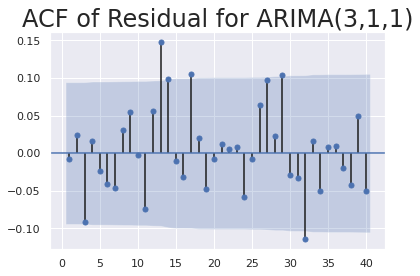

In [52]:
#df['res_temp'] = results_t_ar_3_i_1_ma_1.resid.iloc[:] #Mettere il migliore tra gli ARMA
#print(sts.adfuller(df.res_temp))
sgt.plot_acf(results_t_ar_3_i_1_ma_1.resid.iloc[:][1:], zero = False, lags = 40)
plt.title("ACF of Residual for ARIMA(3,1,1)", size=24)
plt.show()

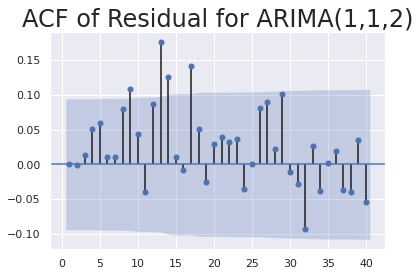

In [53]:
sgt.plot_acf(results_t_ar_1_i_1_ma_2.resid.iloc[:][1:], zero = False, lags = 40)
plt.title("ACF of Residual for ARIMA(1,1,2)", size=24)
plt.show()

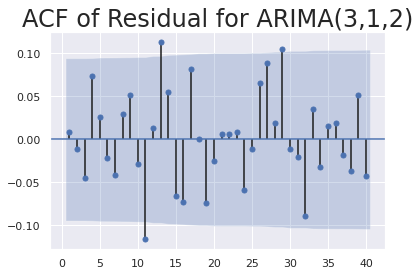

In [54]:
sgt.plot_acf(results_t_ar_3_i_1_ma_2.resid.iloc[:][1:], zero = False, lags = 40)
plt.title("ACF of Residual for ARIMA(3,1,2)", size=24)
plt.show()

## ARIMAX

In [55]:
results_t_ar_3_i_1_ma_1_X_h = ARIMA(df.temperature, exog = df.humidity, order=(3,1,1)).fit() #ORDER?
results_t_ar_3_i_1_ma_1_X_h.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:          D.temperature   No. Observations:                  432
Model:                 ARIMA(3, 1, 1)   Log Likelihood                 256.298
Method:                       css-mle   S.D. of innovations              0.134
Date:                Sat, 11 Jul 2020   AIC                           -498.596
Time:                        16:19:57   BIC                           -470.117
Sample:                             1   HQIC                          -487.352
                                                                              
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -0.3621      0.192     -1.891      0.059      -0.737       0.013
humidity                0.0086      0.004      1.944      0.052    -7.1e-05       0.017
ar.L1.D.temperature     1.2173      0.056     21.716      0.000       1.107       1.327
ar.L2.D.temperature    -0.3482      0.074     -4.703      0.000      -0.493      -0.203
ar.L3.D.temperature     0.0996      0.049      2.043      0.041       0.004       0.195
ma.L1.D.temperature    -0.9117      0.030    -30.182      0.000      -0.971      -0.853
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0383           -0.0000j            1.0383           -0.0000
AR.2            1.2292           -2.8567j            3.1100           -0.1853
AR.3            1.2292           +2.8567j            3.1100            0.1853
MA.1            1.0968           +0.0000j            1.0968            0.0000
-----------------------------------------------------------------------------
"""

In [56]:
results_t_ar_3_i_1_ma_1_X_p = ARIMA(df.temperature, exog = df.pressure, order=(3,1,1)).fit() #ORDER?
results_t_ar_3_i_1_ma_1_X_p.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:          D.temperature   No. Observations:                  432
Model:                 ARIMA(3, 1, 1)   Log Likelihood                 249.649
Method:                       css-mle   S.D. of innovations              0.136
Date:                Sat, 11 Jul 2020   AIC                           -485.298
Time:                        16:20:01   BIC                           -456.819
Sample:                             1   HQIC                          -474.055
                                                                              
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   2.9822      1.810      1.648      0.099      -0.565       6.530
pressure               -0.0029      0.002     -1.644      0.100      -0.006       0.001
ar.L1.D.temperature     0.1748        nan        nan        nan         nan         nan
ar.L2.D.temperature     0.0252        nan        nan        nan         nan         nan
ar.L3.D.temperature    -0.0329        nan        nan        nan         nan         nan
ma.L1.D.temperature     0.1574        nan        nan        nan         nan         nan
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -3.4103           -0.0000j            3.4103           -0.5000
AR.2            2.0889           -2.1360j            2.9877           -0.1268
AR.3            2.0889           +2.1360j            2.9877            0.1268
MA.1           -6.3528           +0.0000j            6.3528            0.5000
-----------------------------------------------------------------------------
"""

In [57]:
results_t_ar_3_i_1_ma_1_X_p = ARIMA(df.temperature, exog = df[['pressure','humidity']], order=(3,1,1)).fit() #ORDER?
results_t_ar_3_i_1_ma_1_X_p.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:          D.temperature   No. Observations:                  432
Model:                 ARIMA(3, 1, 1)   Log Likelihood                 252.162
Method:                       css-mle   S.D. of innovations              0.135
Date:                Sat, 11 Jul 2020   AIC                           -488.325
Time:                        16:20:02   BIC                           -455.777
Sample:                             1   HQIC                          -475.475
                                                                              
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -1.2910      1.713     -0.754      0.451      -4.648       2.066
pressure                0.0010      0.002      0.588      0.557      -0.002       0.004
humidity                0.0069      0.003      2.414      0.016       0.001       0.013
ar.L1.D.temperature     0.1691        nan        nan        nan         nan         nan
ar.L2.D.temperature     0.0190        nan        nan        nan         nan         nan
ar.L3.D.temperature    -0.0407        nan        nan        nan         nan         nan
ma.L1.D.temperature     0.1499        nan        nan        nan         nan         nan
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.8396           -2.0674j            2.7674           -0.1343
AR.2            1.8396           +2.0674j            2.7674            0.1343
AR.3           -3.2117           -0.0000j            3.2117           -0.5000
MA.1           -6.6689           +0.0000j            6.6689            0.5000
-----------------------------------------------------------------------------
"""

In [58]:
print("\nARIMA(3,1,1) vs ARIMAX(3,1,1) hum",LLR_test(results_t_ar_3_i_1_ma_1, results_t_ar_3_i_1_ma_1_X_h))
print("\nARIMA(3,1,1) vs ARIMAX(3,1,1) press",LLR_test(results_t_ar_3_i_1_ma_1, results_t_ar_3_i_1_ma_1_X_p))


ARIMA(3,1,1) vs ARIMAX(3,1,1) hum 0.046

ARIMA(3,1,1) vs ARIMAX(3,1,1) press 1.0


## SARIMAX

In [73]:
results_t_sarimax_h = SARIMAX(df.temperature, order=(3,1,1), seasonal_order = (2,0,1,int(df_dim/3))).fit() #ORDER? STAGIONALITY?
results_t_sarimax_h.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                         temperature   No. Observations:                  433
Model:             SARIMAX(3, 1, 1)x(2, 0, 1, 144)   Log Likelihood                 250.080
Date:                             Sat, 11 Jul 2020   AIC                           -484.160
Time:                                     17:20:09   BIC                           -451.613
Sample:                                          0   HQIC                          -471.310
                                             - 433                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3597      0.543     -0.662      0.508      -1.424       0.705
ar.L2          0.1983      0.168      1.181      0.238      -0.131       0.528
ar.L3         -0.0715      0.061     -1.179      0.238      -0.190       0.047
ma.L1          0.6882      0.544      1.265      0.206      -0.378       1.755
ar.S.L144      0.0208    793.555   2.62e-05      1.000   -1555.317    1555.359
ar.S.L288      0.0430     31.417      0.001      0.999     -61.533      61.619
ma.S.L144      0.0171    794.987   2.16e-05      1.000   -1558.128    1558.163
sigma2         0.0184      0.001     16.405      0.000       0.016       0.021
===================================================================================
Ljung-Box (Q):                       71.69   Jarque-Bera (JB):               712.00
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.66   Skew:                             1.06
Prob(H) (two-sided):                  0.01   Kurtosis:                         8.92
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
results_t_sarimax_p = SARIMAX(df.temperature, order=(3,1,1), seasonal_order = (2,0,1,5)).fit() #ORDER? STAGIONALITY?
results_t_sarimax_p.summary()

## Make predictions

In [ ]:
start_date = "..."
end_date = "..."

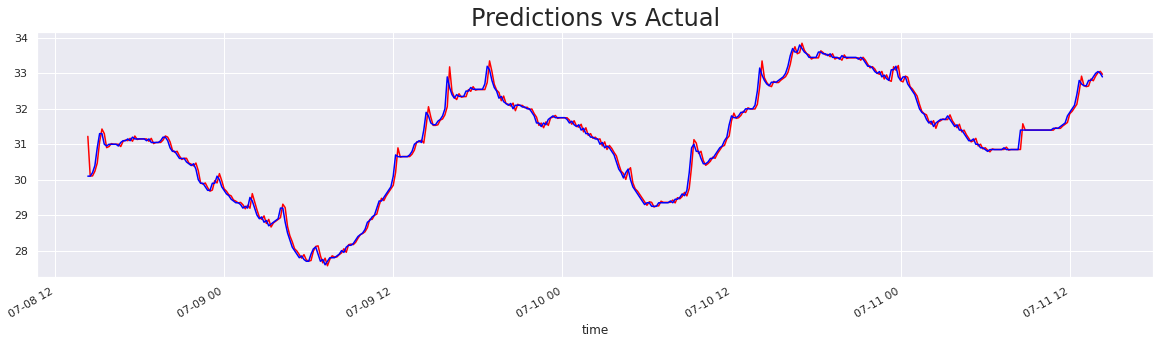

In [61]:
#AR
df_pred_t_ar_2 = results_t_ar_2.predict()
df_pred_t_ar_2.plot(figsize = (20,5), color = "red")
df.temperature.plot(color="blue")
plt.title("Predictions vs Actual", size = 24)
plt.show()

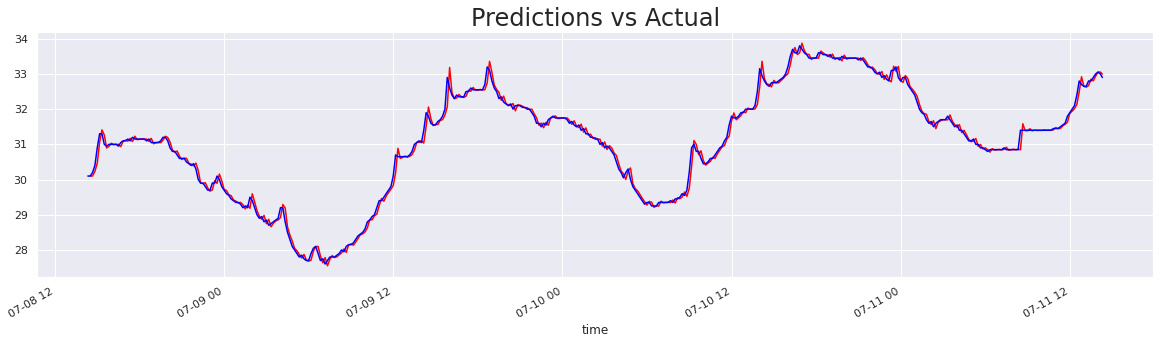

In [75]:
#SARIMAX
df_t_sarimax_h = results_t_sarimax_h.predict()
df_t_sarimax_h[1:].plot(figsize = (20,5), color = "red")
df.temperature.plot(color="blue")
plt.title("Predictions vs Actual", size = 24)
plt.show()

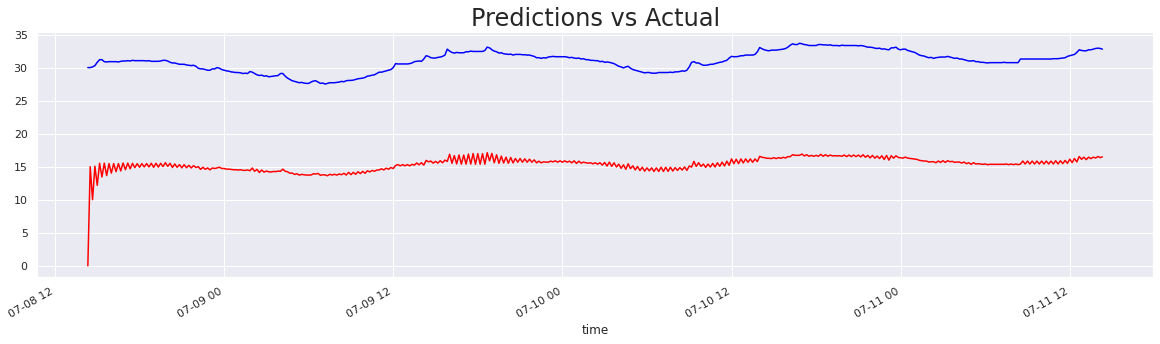

In [62]:
#MA
df_pred_t_ma_1 = results_t_ma_1.predict()
df_pred_t_ma_1.plot(figsize = (20,5), color = "red")
df.temperature.plot(color="blue")
plt.title("Predictions vs Actual", size = 24)
plt.show()

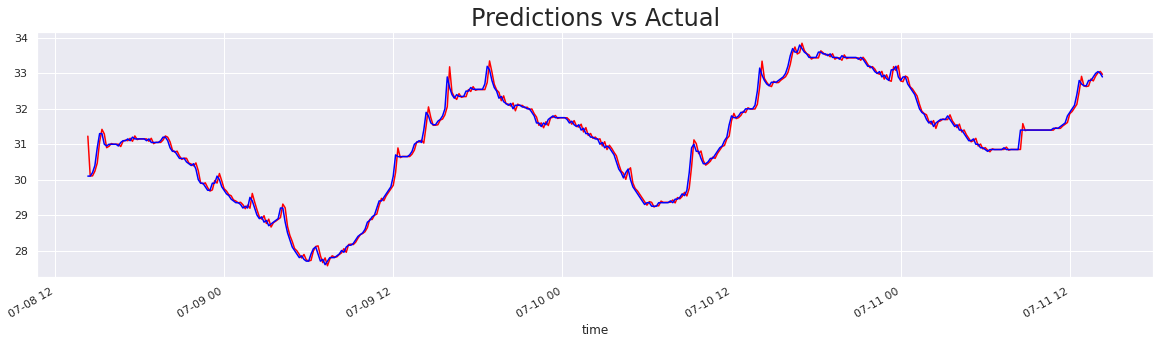

In [64]:
#ARMA
df_pred_t_ar_2_ma_1 = reults_t_ar_2_ma_1.predict()
df_pred_t_ar_2_ma_1.plot(figsize = (20,5), color = "red")
df.temperature.plot(color="blue")
plt.title("Predictions vs Actual", size = 24)
plt.show()

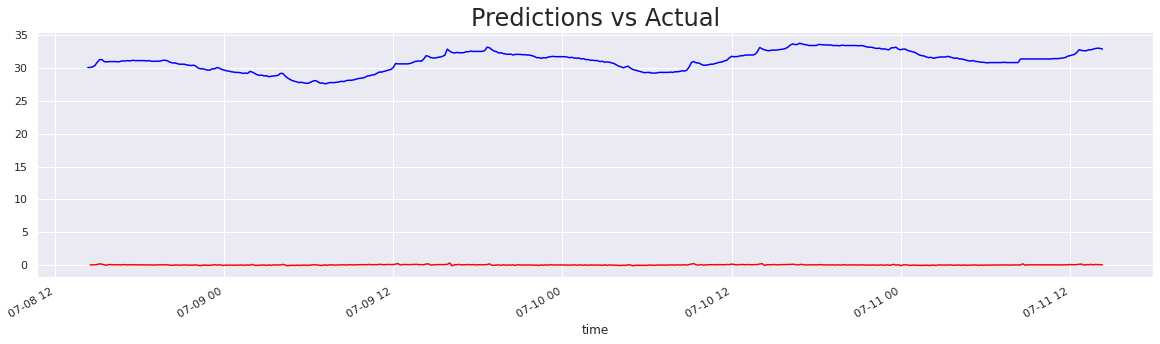

In [71]:
#ARIMA
df_pred_t_ar_3_i_1_ma_1 = results_t_ar_3_i_1_ma_1.predict()
df_pred_t_ar_3_i_1_ma_1.plot(figsize = (20,5), color = "red")
df.temperature.plot(color="blue")
plt.title("Predictions vs Actual", size = 24)
plt.show()

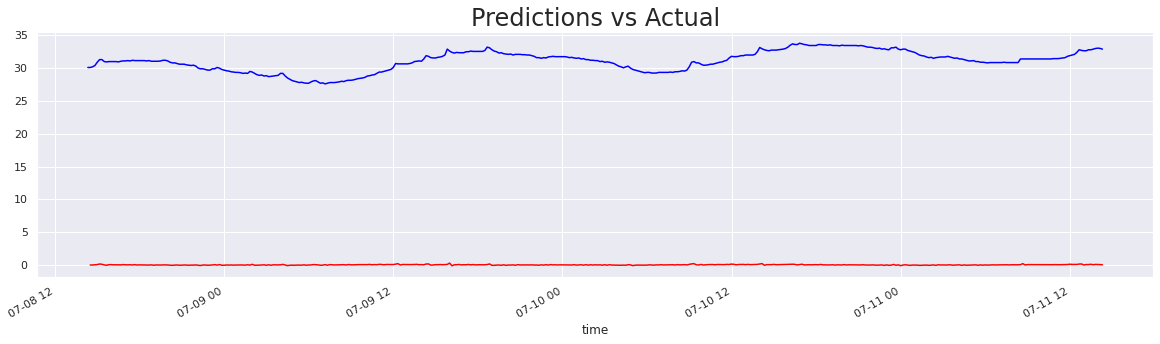

In [70]:
#ARIMAX
df_pred_t_ar_3_i_1_ma_1_X_h = results_t_ar_3_i_1_ma_1_X_h.predict()
df_pred_t_ar_3_i_1_ma_1_X_h.plot(figsize = (20,5), color = "red")
df.temperature.plot(color="blue")
plt.title("Predictions vs Actual", size = 24)
plt.show()

In [ ]:
#SARIMAX
results_t_sarimax_h = results_t_sarimax_h.predict(start = start_date, end = end_date)
results_t_sarimax_h[start_date:end_date].plot(figsize = (20,5), color = "red")
df_test.ftse[start_date:end_date].plot(color="blue")
plt.title("Predictions vs Actual", size = 24)
plt.show()

# Humidity

## MA(1)

In [ ]:
model_h_ma_1 = ARIMA(df.humidity, order=(0,0,1))
results_h_ma_1 = model_h_ma_1.fit()
results_h_ma_1.summary()

## Auto ARIMA

In [ ]:
from pmdarima.arima import auto_arima
model_t_auto = auto_arima(df.temperature[1:], exogenous = df[['humidity', 'pressure']][1:], 
                         m=145, max_order = None, max_p = 7, max_q = 7, max_d = 2, max_P = 4, 
                         max_Q = 4, max_D = 2, maxiter = 50, alpha = 0.05, n_jobs = -1, trend = 'ct')
model_t_auto.summary()